<a href="https://colab.research.google.com/github/kev1092/Lab3_MachineVision_HH/blob/main/Lab_3_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/kev1092/Lab2-CV-course-HH

Cloning into 'Lab2-CV-course-HH'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 107 (delta 15), reused 0 (delta 0), pack-reused 76
Receiving objects: 100% (107/107), 15.24 MiB | 13.66 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Lab 3: Feature Extraction

In computer vision, feature extraction refers to compressing/abstracting the information from a given image into a reduced vector form, called feature vector.

In this lab, we will focus on object recognition applications. Virtually any object recognition application would do feature extraction to understand the image's content and generate a valuable set of features able to describe it as best as possible. This feature vector can then be used to recognize and identify objects much easier and accurately than making direct pixel comparisons.

There are many different algorithms to do feature extraction, depending on the type of features that it focuses on, such as texture, color, or shape, if it describes the image as a whole or just local information, or just different strategies for the same goal.

This lab will focus on two different types of feature extraction algorithms, local and global descriptors.

## **Local Descriptors**
As their name suggests, local descriptors look to describe a small area of the image. In this type of descriptor, we can differentiate two steps:



*   Keypoint detection: In this step, we try to identify potential locations or points in the image that could contain useful information to describe an object.
*   Local feature description: In this step, we try to describe the area around the keypoint by extracting valuable information like texture.

We will be analyzing one of the most commonly known and powerful local descriptors in computer vision, Scale Invariant Feature Transform (SIFT)

### **SIFT**

Please take into account that this will be just a brief explanation of the SIFT algorithm. For more information, you can refer to the original paper available [here](https://www.cs.ubc.ca/~lowe/papers/iccv99.pdf) or, for example, OpenCV auxiliary [documentation ](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html)


SIFT is a patented algorithm (although apparently, the license expired in March 2020) first introduced by David G. Lowe in the paper "Lowe, D. G. (1999, September). Object recognition from local scale-invariant features. In Proceedings of the seventh IEEE international conference on computer vision (Vol. 2, pp. 1150-1157). Ieee." SIFT features are invariant to translation, scaling, and rotation and partially invariant to illumination changes or affine transformation.

SIFT uses the Differentiate of Gaussians for keypoint detection, an algorithm introduced by the same author in the same paper.

###### **Keypoint detection: Difference of Gaussians (DoG)**

DoG is used to extract "blob"-like regions. "BLOB" stands for Binary Large Object. It is a common term within computer vision (even though some specific areas or libraries can use it to refer to slightly different things). We call blobs to some amorphous region of pixels that share some properties, like intensity.

We saw in our previous lab that Gaussians are low pass filters. The main idea is to use Gaussians of different σ-values and subtract them together to create a band-pass filter. We extend this to different resolutions of the image to detect blobs at different scales in the Gaussian pyramid, as shown in the image below


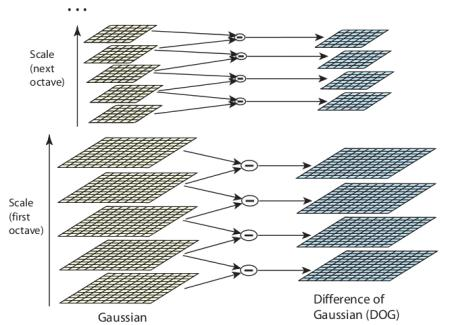

We then need to find local extrema in the DoG both in space and across the different scales. We do that by checking the 26-pixel neighborhood around a pixel. We consider the 8 pixels neighborhood around a specific level of the DoG and the 9-pixel neighborhood of the level above and below. If that pixel contains a local maxima or minima, we mark that as a keypoint. Finally, a pruning step is made to remove the low contrast keypoint.

Finally, we assign a scale value to each keypoint to identify the scale level at which the keypoint is located. An orientation is calculated based on the highest orientation values in a weighted gradient histogram surrounding the keypoint.

Let us see an example of this!

Text(0.5, 1.0, 'Target Image')

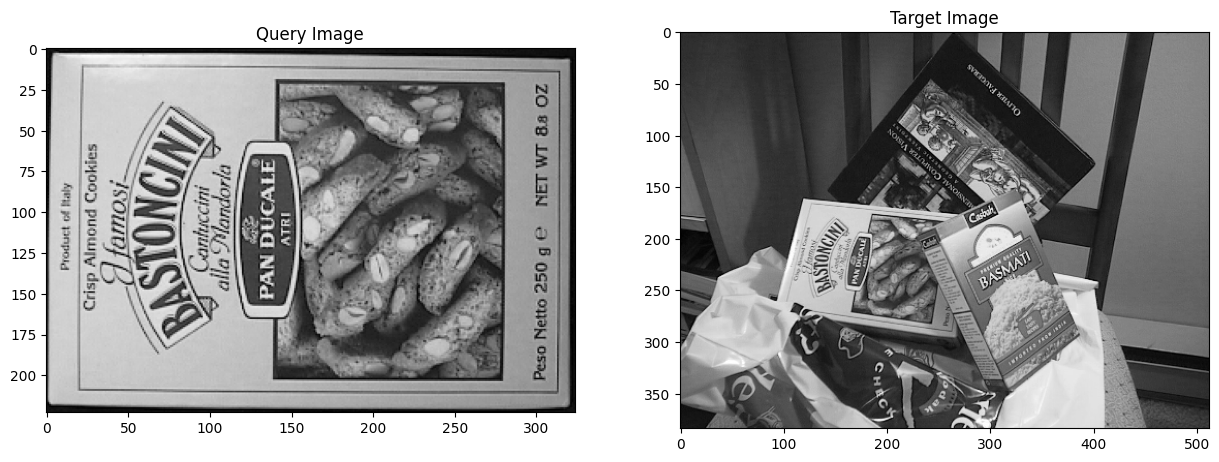

In [ ]:
# let's import our two images for this part of the lab
# img_q will be the query image that we would like to recognize/detect/match in the target image

img_q = cv2.imread("Lab2-CV-course-HH/box.png",cv2.IMREAD_GRAYSCALE)
img_t = cv2.imread("Lab2-CV-course-HH/box_in_scene.png",cv2.IMREAD_GRAYSCALE)

#ok so let's check them!

fig = plt.figure(figsize=(15, 12), dpi=100)
ax = fig.add_subplot(1, 2, 1)
plt.imshow(img_q,cmap="gray")
ax.set_title('Query Image')
ax = fig.add_subplot(1,2,2)
plt.imshow(img_t,cmap="gray")
ax.set_title("Target Image")



As you can see in this section, we will be trying to find in the target image this box of cookies. Both instances of the same object differ in scale, orientation and illumination. Furthermore, the target image has some partial occlusion and a different perspective.

Now let us find our keypoints.

SIFT found 604 keypoints in the query image and 969 keypoints in the target image


Text(0.5, 1.0, 'Keypoints in Target Image')

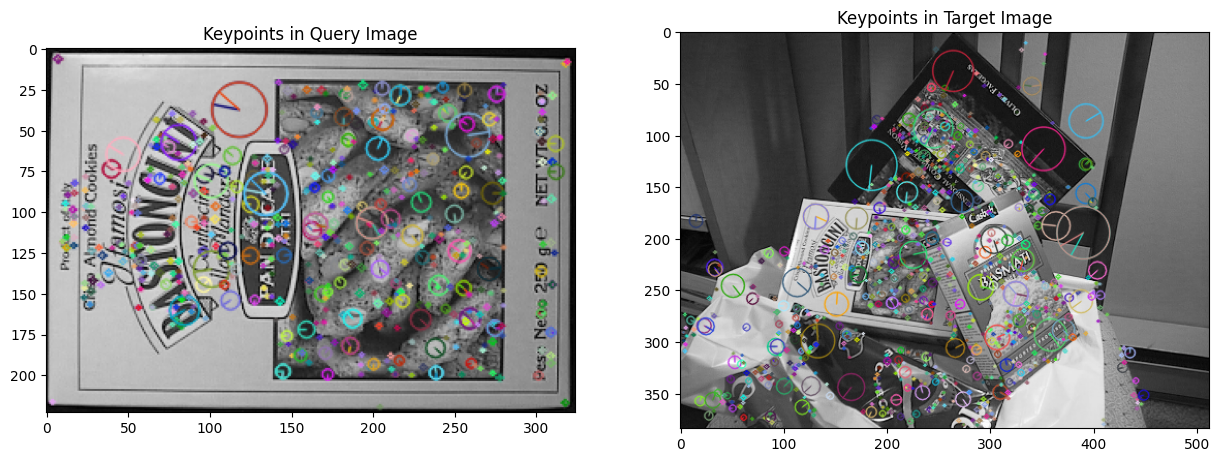

In [ ]:
# we create an instance for our detector

sift = cv2.SIFT_create()

kp_q = sift.detect(img_q,None)
kp_t = sift.detect(img_t,None)

print("SIFT found {} keypoints in the query image and {} keypoints in the target image".format(len(kp_q),len(kp_t)))

# we can draw our keypoints in the images too
img_kpq = img_q.copy()
img_kpt = img_t.copy()
img_kpq = cv2.drawKeypoints(img_q,kp_q,img_kpq, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_kpt = cv2.drawKeypoints(img_t,kp_t,img_kpt, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig = plt.figure(figsize=(15, 12), dpi=100)
ax = fig.add_subplot(1, 2, 1)
plt.imshow(img_kpq,cmap="gray")
ax.set_title('Keypoints in Query Image')
ax = fig.add_subplot(1,2,2)
plt.imshow(img_kpt,cmap="gray")
ax.set_title("Keypoints in Target Image")


We can see that the number of keypoints varied a lot between images, which makes sense due to the difference in size and complexity. We can also see that the keypoint detection algorithm detected several keypoints in our cookie box in both pictures. Now it begs the question.... how can we match all these different keypoints?

###### **Feature description: SIFT**

Once we have our keypoint locations, we need to create a feature vector that describes the surrounding of that pixel. For that, SIFT extracts an area of 16x16 pixels, divides it into 16 regions of 4x4, and calculates the gradient information in that region. Next, it will construct an 8-bin histogram of the magnitude and orientation with the information of all pixels in that 4x4 subregion. Finally, it will combine all gradient histograms to create a 4x4x8=128 feature vector.


In [ ]:
# since we extracted the keypoints before, we can extract the features by calling "compute" in our sift handler
kp_q, desc_q = sift.compute(img_q,kp_q)
kp_t, desc_t = sift.compute(img_t,kp_t)

# now we have on one variable our keypoints, and their corresponding descriptor in the other.
# we can check that their sizes match and correspond to the same number of keypoints from before

print("number of keypoints in query image is {}, number of feature vectors {}, the size of each feature vector is {}".format(len(kp_q),len(desc_q),len(desc_q[0])))
print("number of keypoints in target image is {}, number of feature vectors {}, the size of each feature vector is {}".format(len(kp_t),len(desc_t),len(desc_t[0])))

# we can also take a look at how this feature vectors look like

print(desc_q[0])

number of keypoints in query image is 604, number of feature vectors 604, the size of each feature vector is 128
number of keypoints in target image is 969, number of feature vectors 969, the size of each feature vector is 128
[  0.   0.   0.   0.   0.   0.   0.   0.   2.   0.   0.   0.   0.   0.
   1.  11.   1.   0.   0.   0.   0.   0.  27.  19.   0.   0.   0.   0.
   0.   0.  57.  11.  15.   0.   0.   0.   0.   0.   0.   8. 154.   2.
   0.   0.   0.   0.  18. 164.  33.   1.   0.   0.   0.   0. 164. 164.
   0.   0.   1.   0.   0.   0. 164.  56.  38.   4.   0.   0.   0.   0.
   0.   2. 164.  64.   0.   0.   0.   0.   1.  55. 154.  35.   2.   0.
   0.   0.  17.  43.   1.   6.   6.   0.   0.   0.  13.   4.  18.   2.
   0.   0.   0.   0.   0.   1. 164.  63.   0.   0.   0.   0.   0.   0.
 164.  37.   0.   0.   0.   0.   0.   0.   5.   4.   1.   0.   0.   0.
   0.   0.]


###### **keypoint matching**

Now that we have our keypoints and their associated descriptor let's see if we can match our images!

In this lab, we will not get into details about the different types of matching algorithms and how they work for keypoint matching. You can find more information about Brute-Force Matcher and FLANN based Matcher [here](https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html)

We will use Brute-Force Matching, which compares all keypoints in the query image against all keypoints in the target image. How do we compare them? We can use any distance or similarity metric that we want. Then we are following Lowe's recommendation and used a ratio test between the best and second-best match for each keypoint to ensure that the match was good. A good match will have a very small ratio since the distance for the best match would be low, and the distance to the second-best match would be high

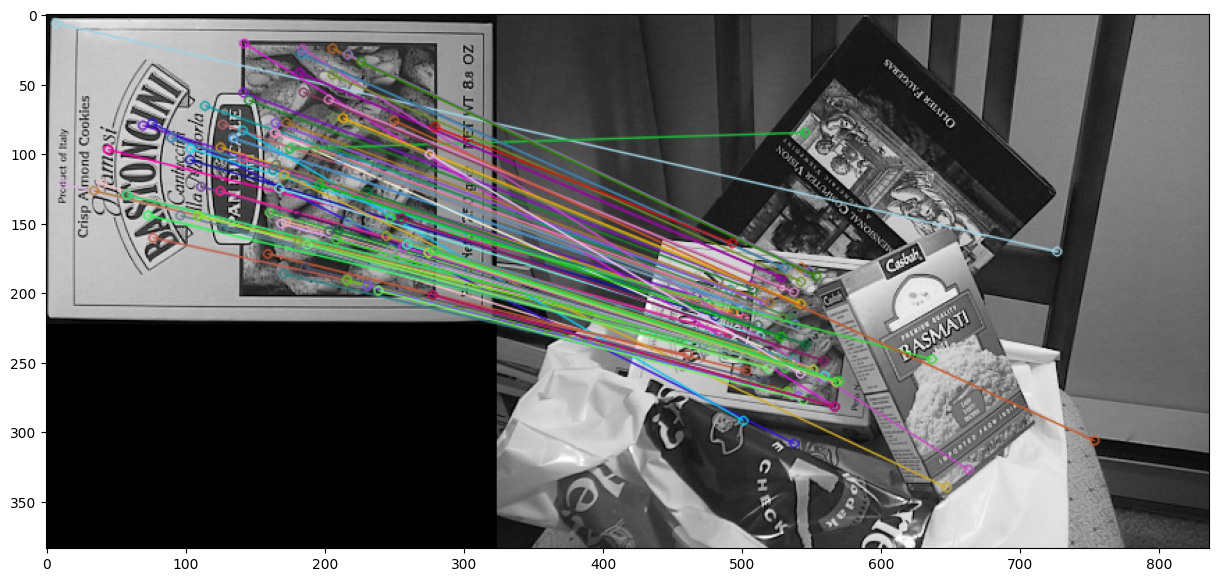

In [ ]:
# we initialize our handler for the matcher algorithm
BFM = cv2.BFMatcher()

# we find the matches between our two descriptors and extract the 2 best matches for Lowe's ratio test
matches = BFM.knnMatch(desc_q,desc_t,k=2)

valid_matches = []

for ImageA,ImageB in matches:
    if ImageA.distance < 0.8*ImageB.distance:
        valid_matches.append(ImageA)

# we can finally draw our keypoint matches between our query and target image!
img_match = cv2.drawMatches(img_q,kp_q,img_t,kp_t,valid_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig = plt.figure(figsize=(15, 12), dpi=100)
plt.imshow(img_match)


We can see that some of the matches are not correct, but the vast majority seem to be fine!

Now that we have our keypoints, descriptors, and matches, what strategy do we follow for object classification? We have our query image, and we can have several target images over which we need to recognize which one has the same object/identity. There are several options; we can have a threshold on the number of correct matches necessary to recognize the object. However, this strategy is susceptible to the number of keypoints in each image. If, because of the image, we can only detect 10 keypoints, but all keypoints are correctly matched, it is still likely to be the correct object. So, another strategy could be to normalize the number of matches with the number of keypoints present in the images.

In [ ]:
dicaprio1 = cv2.imread("Lab2-CV-course-HH/dicaprio1.jpg",cv2.IMREAD_GRAYSCALE)
dicaprio2 = cv2.imread("Lab2-CV-course-HH/dicaprio2.jpg",cv2.IMREAD_GRAYSCALE)
brad = cv2.imread("Lab2-CV-course-HH/brad.jpg",cv2.IMREAD_GRAYSCALE)

In [ ]:
kp_d1, desc_d1 = sift.detectAndCompute(dicaprio1,None)
kp_d2, desc_d2 = sift.detectAndCompute(dicaprio2,None)
kp_b, desc_b = sift.detectAndCompute(brad,None)

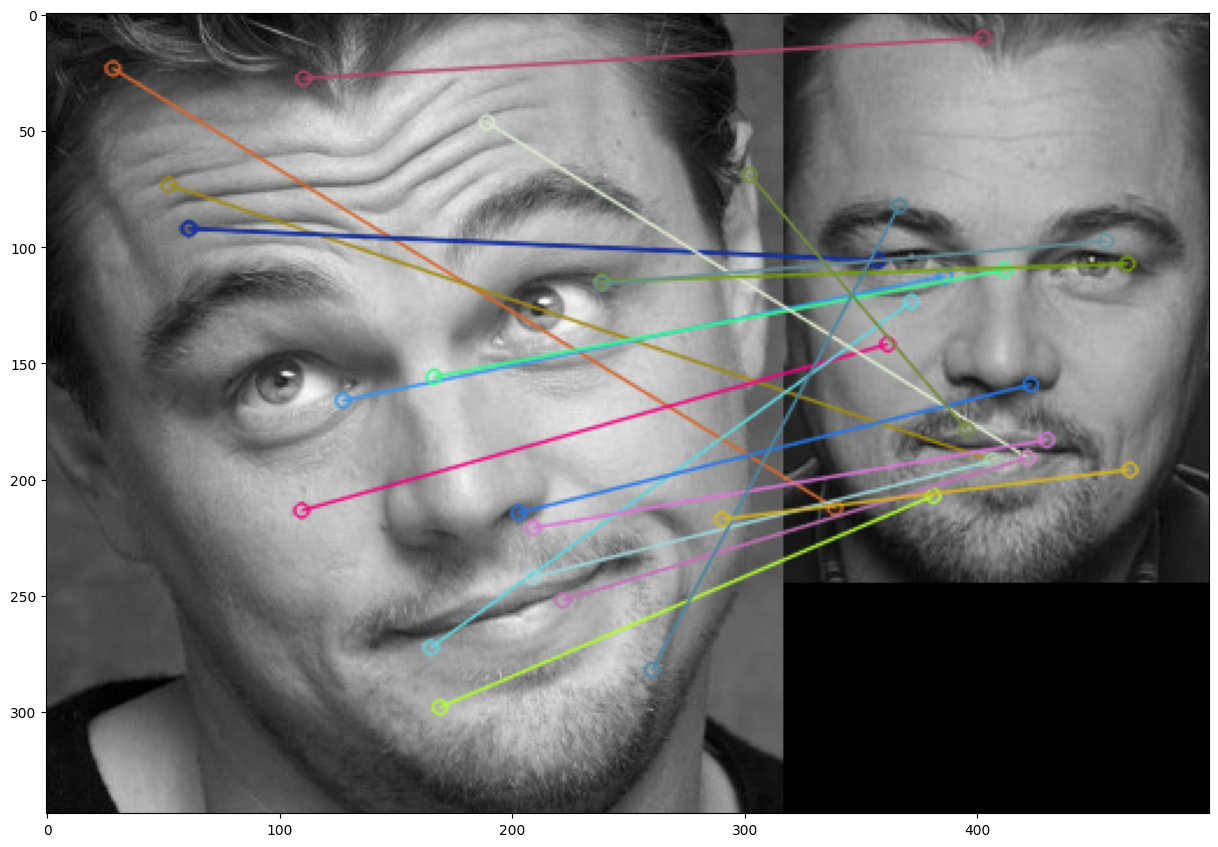

In [ ]:

# we find the matches between our two descriptors and extract the 2 best matches for Lowe's ratio test
matches = BFM.knnMatch(desc_d2,desc_d1,k=2)

dicaprio_matches = []

for ImageA,ImageB in matches:
    if ImageA.distance < 0.8*ImageB.distance:
        dicaprio_matches.append(ImageA)

# we can finally draw our keypoint matches between our query and target image!
dicaprio_match = cv2.drawMatches(dicaprio2,kp_d2,dicaprio1,kp_d1,dicaprio_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig = plt.figure(figsize=(15, 12), dpi=100)
plt.imshow(dicaprio_match)

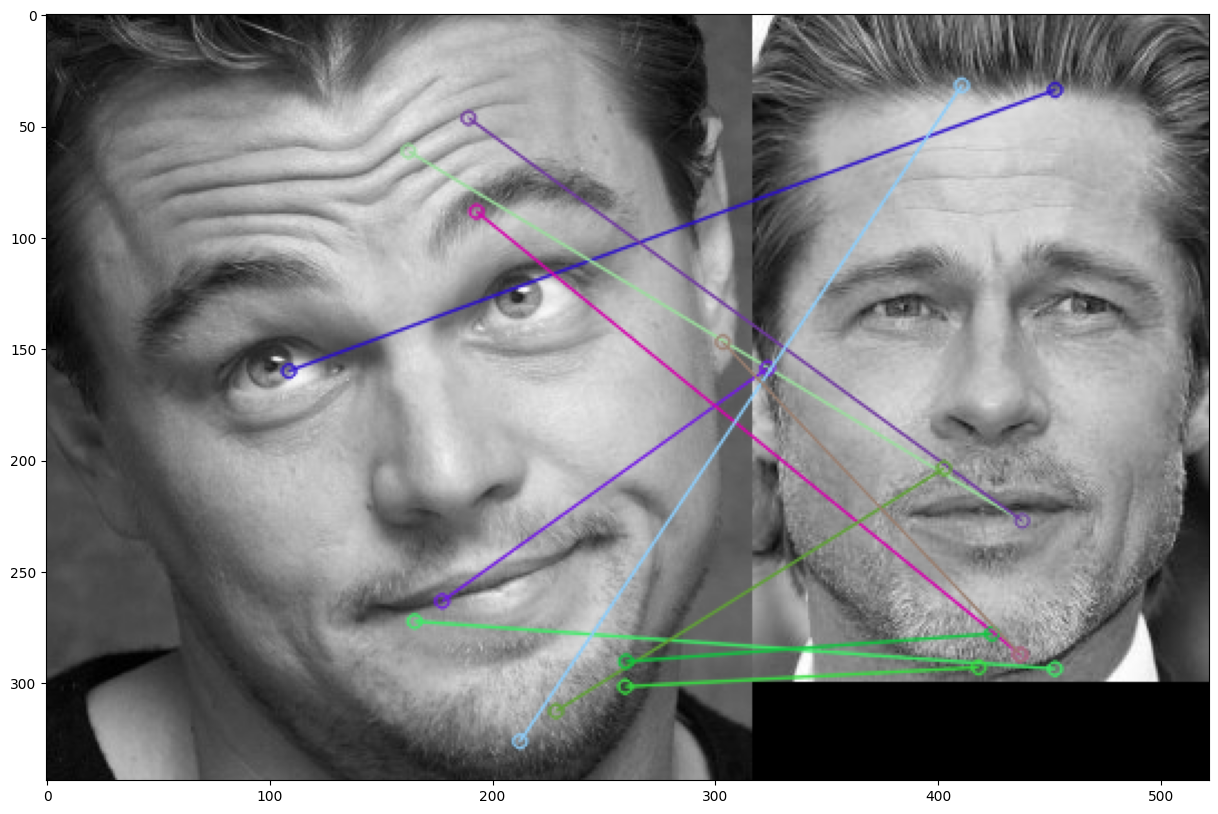

In [ ]:
# we find the matches between our two descriptors and extract the 2 best matches for Lowe's ratio test
matches = BFM.knnMatch(desc_d2,desc_b,k=2)

brad_matches = []

for ImageA,ImageB in matches:
    if ImageA.distance < 0.8*ImageB.distance:
        brad_matches.append(ImageA)

# we can finally draw our keypoint matches between our query and target image!
brad_match = cv2.drawMatches(dicaprio2,kp_d2,brad,kp_b,brad_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig = plt.figure(figsize=(15, 12), dpi=100)
plt.imshow(brad_match)

In [ ]:
# TO DO:

# print the number of keypoints in dicaprio1

# print the number of keypoints in dicaprio2

# print the number of keypoints in brad

# print the number of matches for dicaprio vs dicaprio

# print the number of matches between dicaprio and brad

# print the ratio of matches between dicaprios over the MINIMUM number of keypoints detected between both images

# print the ratio of matches between dicaprio and brad over the MINIMUM number of keypoints detected between both images

# take a look to OpenCV's detectAndCompute function and check that the descriptors obtained are exactly the same than when using the functions detect() and compute(). Check this for dicaprio1, dicaprio2 and brad images.




## Global descriptor

Global descriptors are usually applied to each pixel in the image and aim to extract information as texture in their neighborhood. After this, one could compare this processed image as a whole for object recognition, but they usually still suffer from things like alignment and error accumulation. For this, we try to compress all this information in a reduced vector form that can help us with the previously mentioned problems and create a reduced database.

### Histogram of Oriented Gradients (HOG)

Histogram of Oriented Gradients was first introduced by Navneet Dalal and Bill Trigs in their CVPR paper ["Histograms of Oriented Gradients for Human Detection"](https://hal.inria.fr/inria-00548512/document)
in 2005.

Since this algorithm works on the extracted gradients, it is at describing textures and shapes. It is somewhat similar to SIFT descriptor in the sense that it tries to encode the local gradients around a point in histograms. For more information on HOG, you can read the original paper, read a more detailed explanation [here](https://learnopencv.com/histogram-of-oriented-gradients/) or watch again the course lectures.





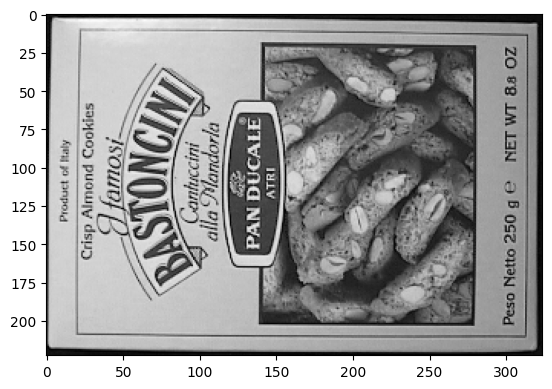

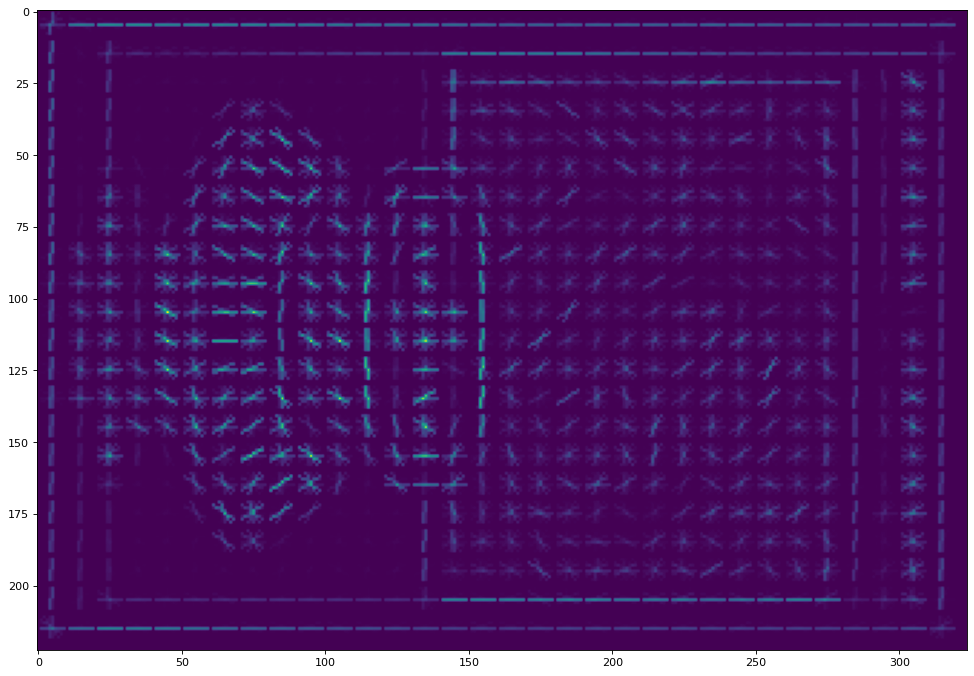

In [ ]:
# we will be using the hog descriptor from skimage since it has visualization tools available for this example
from skimage import feature
from skimage import exposure

plt.imshow(img_q,cmap="gray")

# These are the usual main parameters to tune in the HOG algorithm.
(H,Himage) = feature.hog(img_q, orientations=9, pixels_per_cell=(10,10), cells_per_block=(2,2),visualize=True)

Himage = exposure.rescale_intensity(Himage, out_range=(0,255))
Himage = Himage.astype("uint8")

fig = plt.figure(figsize=(15, 12), dpi=80)
plt.imshow(Himage)



In [ ]:
# TO DO:
# These are the usual main parameters to tune in the HOG algorithm.
# Vary these parameters and check in the plot show they affect the representation of the image

As you can see, HOG describes the general outline of the box's front part very well. As we said earlier, this is because HOG focuses on the gradient information over the image, which is excellent for detecting lines and shapes. Furthermore, we can see the dominant gradients and their intensity at each point in the image.

HOG has traditionally been used not only for object recognition but also for object detection. There are several approaches for object detection with HOG. A straightforward way is to do template matching over the HOG image, but this approach, even though much better than direct pixel template matching, can still be improved by pairing it with an object recognition model trained with HOG templates.

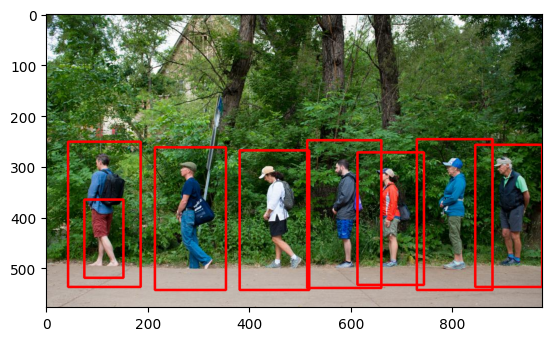

In [ ]:
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

people_color = cv2.cvtColor(cv2.imread("Lab2-CV-course-HH/people.jpg"),cv2.COLOR_BGR2RGB)
people_gray = cv2.cvtColor(people_color,cv2.COLOR_RGB2GRAY)


bbox, weights = hog.detectMultiScale(people_gray,winStride = (2,2), padding=(10,10),scale=1.02)

# Drawing the regions in the Image
for (x, y, w, h) in bbox:
    cv2.rectangle(people_color, (x, y),
                  (x + w, y + h),
                  (255, 0, 0), 4)

plt.imshow(people_color)

# TO DO:
# import other images with people and analyze how good the detector works

In the code above, we use OpenCV's HOG descriptor, set its detector to SVM, and use its default people detector.

After importing our test image, we use the descriptor's multiscale detection method to find the persons in our image. One interesting parameter that we are passing the detectMultiScale function is the winStride. This parameter tells how many pixels/positions skip during each step during convolution. In the previous lab, in both the explanation and example, we do the convolutions over each pixel, which is the same as setting the winStride to be (1,1) and advancing 1 position in each coordinate axis. This time we set it to skip 1 position each time. This will affect the detector's accuracy but will significantly help the speed and computation of the process, which is one of the main issues during object detection since it is a very expensive process. You can read more about the detectMultiScale and hyperparameters options [here](https://pyimagesearch.com/2015/11/16/hog-detectmultiscale-parameters-explained/)

We can see that even though we do effectively detect all people in the scene, it is not perfect; since there appears to be a False Positive detection, the lower body of the first person is detected as another person. One way to solve this issue is to use an algorithm called Non-Maxima-Suppression (NMS), which focuses on removing overlapping bounding boxes due to multiple detections of the same instance. This algorithm is not perfect either, of course, and a bad configuration can produce False Negatives, meaning a failure to detect an instance of an object in the scene.

We will use HOG for object recognition/classification problems in the following code. We will use three different face images for this example. These images were taken from the [Labelled Faces in the Wild (LFW)](http://vis-www.cs.umass.edu/lfw/).


Text(0.5, 1.0, 'FaceB1')

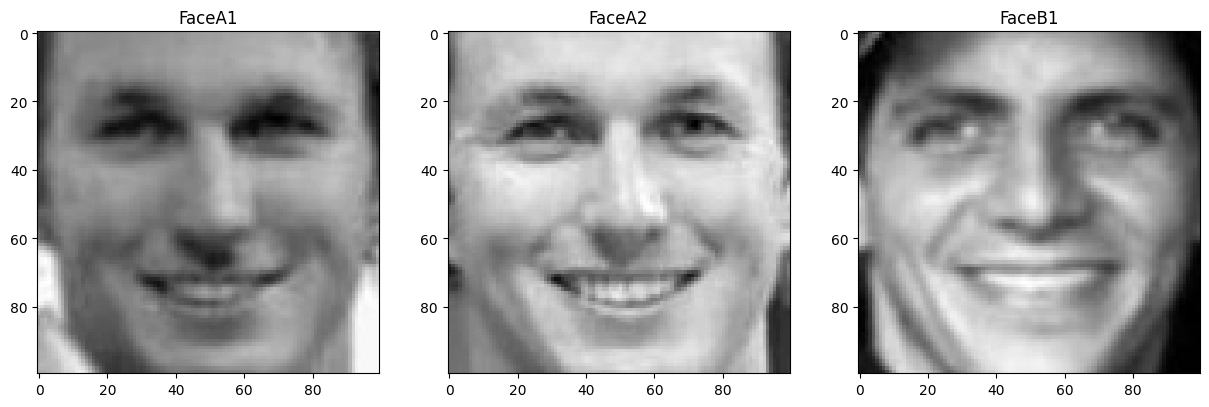

In [ ]:
# we import the images
faceA1 = cv2.imread("Lab2-CV-course-HH/faceA1.jpg",cv2.IMREAD_GRAYSCALE)
faceA2 = cv2.imread("Lab2-CV-course-HH/faceA2.jpg",cv2.IMREAD_GRAYSCALE)
faceB1 = cv2.imread("Lab2-CV-course-HH/faceB1.jpg",cv2.IMREAD_GRAYSCALE)

# we extract the feature vectors
HA1 = feature.hog(faceA1, orientations=9, pixels_per_cell=(10,10), cells_per_block=(2,2))
HA2 = feature.hog(faceA2, orientations=9, pixels_per_cell=(10,10), cells_per_block=(2,2))
HB1 = feature.hog(faceB1, orientations=9, pixels_per_cell=(10,10), cells_per_block=(2,2))

# Let's plot our images:
fig = plt.figure(figsize=(15, 12), dpi=100)
ax = fig.add_subplot(1, 3, 1)
plt.imshow(faceA1,cmap="gray")
ax.set_title('FaceA1')
ax = fig.add_subplot(1,3,2)
plt.imshow(faceA2,cmap="gray")
ax.set_title("FaceA2")
ax = fig.add_subplot(1,3,3)
plt.imshow(faceB1,cmap="gray")
ax.set_title("FaceB1")

After extracting the feature vectors we can use them to compare the images. But let's check the difference in sizes and distances when comparing images directly and extract features using HOG

In [ ]:
print("images shape: {}".format(faceA1.shape))
print("feature vector size: {}".format(len(HA1)))

distA_I = np.sqrt(np.sum((faceA1-faceA2)**2))
distB_I = np.sqrt(np.sum((faceA1-faceB1)**2))
print("pixel-wise distance between same person: {} ".format(distA_I))
print("pixel-wise distance between different persons: {} ".format(distB_I))

distA = np.sqrt(np.sum((HA1 - HA2)**2))
distB = np.sqrt(np.sum((HA1 - HB1)**2))
print("distance between feature vectors from the same person: {}".format(distA))
print("distance between feature vectors from different persons: {}".format(distB))

print("The distance between different persons is {} times the distance between same person for direct pixel comparison".format(distB_I/distA_I))
print("The distance between different persons is {} times the distance between same person for HOG".format(distB/distA))

images shape: (100, 100)
feature vector size: 2916
pixel-wise distance between same person: 1065.824563424957 
pixel-wise distance between different persons: 1031.6016673115646 
distance between feature vectors from the same person: 4.2594823848012995
distance between feature vectors from different persons: 6.491350145746221
The distance between different persons is 0.9678906854957261 times the distance between same person for direct pixel comparison
The distance between different persons is 1.5239762861583088 times the distance between same person for HOG


Here we can see different things. We can see the massive difference in the distance metric when directly comparing two different images and when comparing feature vectors, from +1000 to units distance. One of the reasons for the increment in the distance is the difference in size between vectors/matrices. However, other reasons like normalization (that HOG does) can also reduce the total distance. Moreover, we also see that the difference in distance between the same-person and different-person when making pixel comparison is much lower (in comparison to the global distance) than with HOG. This will affect the accuracy of the future recognition model. Finally, another thing that we can see, and most important, is that the distance between different persons is lower when making a direct comparison! However, this effect is fixed when processing the images by extracting the features from the image. If we would not do HOG, we would missclasify and recognize the image as being another person!

In [ ]:
# TO DO:
# Vary the parameters from HOG and check how they affect the size of the feature vectors and the distance between the images

### Local Binary Patterns (LBP)

Local Binary Pattern is a local texture description algorithm first introduced in "Ojala, T., Pietikainen, M., & Harwood, D. (1994, October). Performance evaluation of texture measures with classification based on Kullback discrimination of distributions. In Proceedings of 12th international conference on pattern recognition (Vol. 1, pp. 582-585). IEEE.". Again, like with HOG, we apply these descriptors locally but throughout the whole image, compared to local feature algorithms like SIFT, where we only do it around a specific keypoint.

LBP describes the pixel intensity relation between the center pixel and the pixel around it to find edges, spots, lines, or constant areas. It can also encode the orientation of these features, although rotation invariance options are available. We can then summarize this information in histograms that describe the texture of subsections of the image/object.
So let's see the algorithm at work!

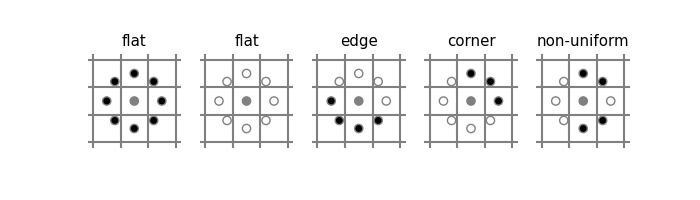

For more information about the parameter and an example of LBP for texture classification, visit [here](https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=local_binary_pattern#skimage.feature.local_binary_pattern) and [here ](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html#sphx-glr-auto-examples-features-detection-plot-local-binary-pattern-py) from the official scikit-image library.

The only configuration parameters that the function takes are:

*   nPoints: number of points to divide the circle around the pixel
*   Radius: radius of the circle
*   method: selection of strategies to follow, for example, algorithm modification to achieve rotation invariance, grayscale invariance...





Text(0.5, 1.0, 'Texture image')

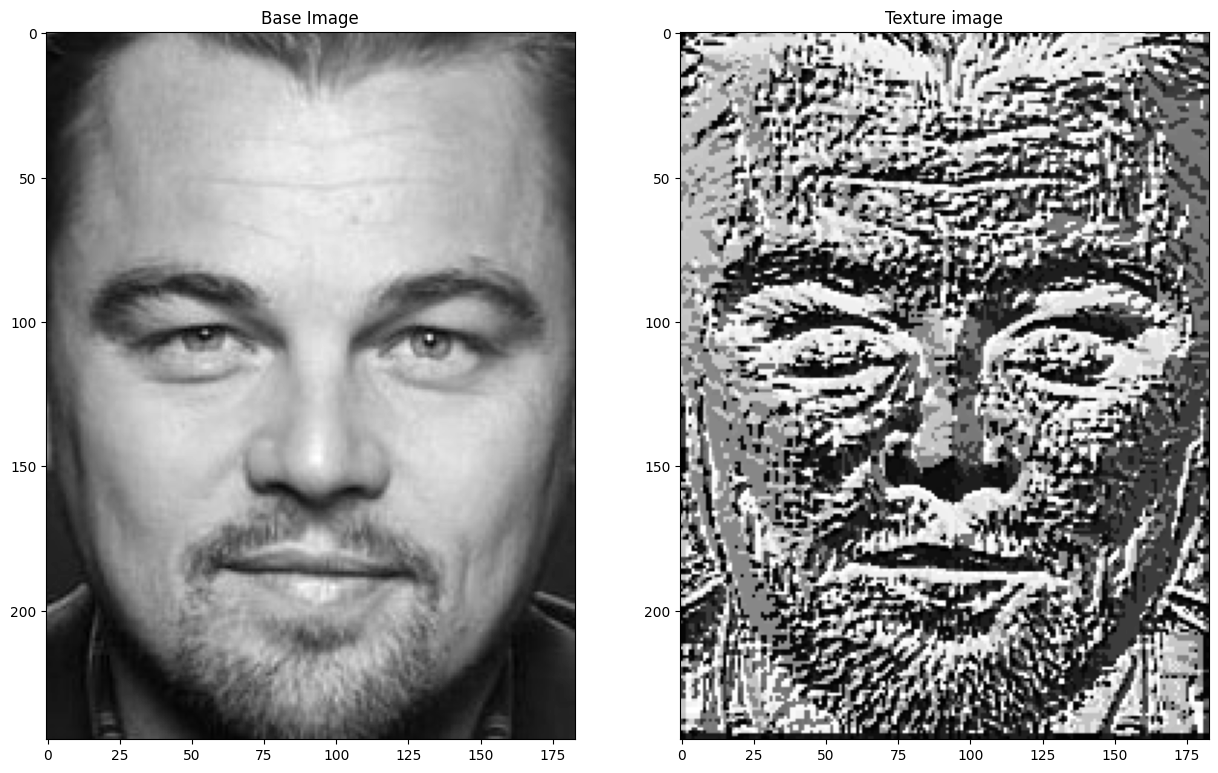

In [ ]:
# we will use again skimage library for this algorithm

nPoints = 8
radius = 2
lbp = feature.local_binary_pattern(dicaprio1, nPoints, radius, method="default")

# Let's take a look at how our image looks
fig = plt.figure(figsize=(15, 12), dpi=100)
ax = fig.add_subplot(1, 2, 1)
plt.imshow(dicaprio1,cmap="gray")
ax.set_title('Base Image')
ax = fig.add_subplot(1,2,2)
plt.imshow(lbp,cmap="gray")
ax.set_title("Texture image")

# TO DO: change the parameters and analyze how they affect the output image

However, we got an image back instead of a feature vector. We could directly compare this texture image. Let's do this with our aligned face images from the LFW dataset and check the performance

In [ ]:
nPoints = 8
radius = 2
lbp_FA1 = feature.local_binary_pattern(faceA1, nPoints, radius, method="default")
lbp_FA2 = feature.local_binary_pattern(faceA2, nPoints, radius, method="default")
lbp_FB1 = feature.local_binary_pattern(faceB1, nPoints, radius, method="default")

distA_I = np.sqrt(np.sum((faceA1-faceA2)**2))
distB_I = np.sqrt(np.sum((faceA1-faceB1)**2))
print("pixel-wise distance between same person: {} ".format(distA_I))
print("pixel-wise distance between different persons: {} ".format(distB_I))

distA_LBP = np.sqrt(np.sum((lbp_FA1-lbp_FA2)**2))
distB_LBP = np.sqrt(np.sum((lbp_FA1-lbp_FB1)**2))
print("LBP pixel-wise distance between same person: {} ".format(distA_LBP))
print("LBP pixel-wise distance between different persons: {} ".format(distB_LBP))

pixel-wise distance between same person: 1065.824563424957 
pixel-wise distance between different persons: 1031.6016673115646 
LBP pixel-wise distance between same person: 8581.762581195078 
LBP pixel-wise distance between different persons: 10834.845545738066 


We can see that even though the distance value has increased with respect to direct pixel comparison, the pictures from the same person would have been correctly recognized! Also, the gap between same-person comparison and different-person comparison has widened a lot!

However, comparing large matrices are not ideal. The distance between high dimensional data is usually not a great indicator. Also, by still making direct pixel comparisons, the recognition process is still heavily affected by alignment, scale, and orientation (Even though our images are aligned and normalized in scale and orientation). A common approach is to use histograms, similar to HOG, to create our feature vector. This approach is commonly referred to as LBPH.

In [ ]:
# we create a histogram of the lbp values
bin_size = 257
lbph_A1,_ = np.histogram(lbp_FA1, bins = np.arange(0,bin_size), density=True)
# Let's take a look at the feature vector
print(lbph_A1)

[0.0226 0.0094 0.0012 0.0096 0.0078 0.0011 0.0057 0.0264 0.002  0.0004
 0.0001 0.0002 0.0048 0.0003 0.0209 0.0742 0.0078 0.0024 0.0001 0.0012
 0.0002 0.     0.0003 0.0013 0.0069 0.0006 0.0002 0.0014 0.0178 0.0004
 0.044  0.0411 0.0022 0.0001 0.     0.     0.0002 0.     0.0003 0.0005
 0.0001 0.     0.     0.     0.0004 0.     0.0002 0.0003 0.0072 0.0015
 0.     0.0004 0.0005 0.     0.0005 0.0001 0.013  0.0008 0.     0.0003
 0.0327 0.0005 0.0151 0.0098 0.0066 0.0012 0.0003 0.0006 0.0014 0.0002
 0.0008 0.0009 0.0006 0.0001 0.     0.     0.0013 0.     0.0003 0.0006
 0.0006 0.     0.     0.     0.     0.     0.     0.     0.0006 0.0001
 0.     0.     0.0005 0.     0.001  0.0005 0.0071 0.0006 0.0001 0.0001
 0.001  0.     0.0001 0.0005 0.0001 0.     0.     0.     0.0007 0.
 0.0004 0.0005 0.0193 0.0007 0.0003 0.0005 0.0008 0.     0.0002 0.0003
 0.0499 0.0004 0.0003 0.0004 0.0264 0.0001 0.0091 0.0031 0.0027 0.01
 0.     0.0168 0.0004 0.0013 0.0001 0.0493 0.0002 0.0001 0.     0.
 0.0003 0.0004 0

In [ ]:
# Now let's compare our images' feature vectors with euclidean distance
lbph_FA1,_ = np.histogram(lbp_FA1, bins = np.arange(0,bin_size), density=True)
lbph_FA2,_ = np.histogram(lbp_FA2, bins = np.arange(0,bin_size), density=True)
lbph_FB1,_ = np.histogram(lbp_FB1, bins = np.arange(0,bin_size), density=True)

distA_LBP = np.sqrt(np.sum((lbp_FA1-lbp_FA2)**2))
distB_LBP = np.sqrt(np.sum((lbp_FA1-lbp_FB1)**2))
print("pixel-wise distance between same person: {} ".format(distA_LBP))
print("pixel-wise distance between different persons: {} ".format(distB_LBP))

distA_LBPH = np.sqrt(np.sum((lbph_FA1-lbph_FA2)**2))
distB_LBPH = np.sqrt(np.sum((lbph_FA1-lbph_FB1)**2))
print("LBPH distance between same person: {} ".format(distA_LBPH))
print("LBPH distance between different persons: {} ".format(distB_LBPH))

print("The distance between different persons is {} times the distance between same person for LBP".format(distB_LBP/distA_LBP))
print("The distance between different persons is {} times the distance between same person for LBPH".format(distB_LBPH/distA_LBPH))

pixel-wise distance between same person: 8581.762581195078 
pixel-wise distance between different persons: 10834.845545738066 
LBPH distance between same person: 0.03265608672207985 
LBPH distance between different persons: 0.07876991811599146 
The distance between different persons is 1.2625431481267135 times the distance between same person for LBP
The distance between different persons is 2.41210524660729 times the distance between same person for LBPH


We can see that we have increased the distance relation between different and same person, so LBPH should work better.

However, this is just a simple implementation of LBPH. The most common approach is to follow a similar procedure as HOG, where we divide the image into subregions via a grid, compute the histograms in each of those blocks or areas and then compare the feature vector obtained from all histograms.

Let's check a simple implementation in the following code.

In [ ]:
# Let's first divide now our image in a grid of smaller patches

grid=[4,4]

lbph_FA1 = []
lbph_FA2 = []
lbph_FB1 = []

n_bins=int(lbp_FA1.max()+1)

# we know all images have the same size and all square
cell_size = faceA1.shape[0]//grid[0]

for i in range(grid[0]):
  for j in range(grid[1]):
    lbph_FA1 = np.concatenate((lbph_FA1,np.histogram(lbp_FA1[i*cell_size:(i+1)*cell_size,j*cell_size:(j+1)*cell_size], bins = n_bins, range = (0,n_bins), density=True)[0]))
    lbph_FA2 = np.concatenate((lbph_FA2,np.histogram(lbp_FA2[i*cell_size:(i+1)*cell_size,j*cell_size:(j+1)*cell_size], bins = n_bins, range = (0,n_bins), density=True)[0]))
    lbph_FB1 = np.concatenate((lbph_FB1,np.histogram(lbp_FB1[i*cell_size:(i+1)*cell_size,j*cell_size:(j+1)*cell_size], bins = n_bins, range = (0,n_bins), density=True)[0]))


distA_LBP = np.sqrt(np.sum((lbp_FA1-lbp_FA2)**2))
distB_LBP = np.sqrt(np.sum((lbp_FA1-lbp_FB1)**2))
print("pixel-wise distance between same person for LBP: {} ".format(distA_LBP))
print("pixel-wise distance between different persons for LBP: {} ".format(distB_LBP))

distA_LBPH = np.sqrt(np.sum((lbph_FA1-lbph_FA2)**2))
distB_LBPH = np.sqrt(np.sum((lbph_FA1-lbph_FB1)**2))
print("LBPH distance between same person: {} ".format(distA_LBPH))
print("LBPH distance between different persons: {} ".format(distB_LBPH))

print("The distance between different persons is {} times the distance between same person for LBP".format(distB_LBP/distA_LBP))
print("The distance between different persons is {} times the distance between same person for LBPH".format(distB_LBPH/distA_LBPH))

pixel-wise distance between same person for LBP: 8581.762581195078 
pixel-wise distance between different persons for LBP: 10834.845545738066 
LBPH distance between same person: 0.4242082507448435 
LBPH distance between different persons: 0.802520828390142 
The distance between different persons is 1.2625431481267135 times the distance between same person for LBP
The distance between different persons is 1.8918086269681005 times the distance between same person for LBPH


Even if, for this case doing the histogram over the whole image achieves better results than concatenating the histograms calculated over smaller regions. This may not hold over bigger and more complex images since doing the histogram over the whole image loses the 2D spatial information of the image that is preserved when doing patches.

Still, image preprocessing and alignment are essential to achieve good performance, as well as some parameter analysis for the data type and task.

# **HOMEWORK**

Besides doing the "TO DO" sections in the lab, you must do the following as homework:

Repeat the SIFT exercise but change the keypoint detection strategies and the descriptor. USE BRISK for keypoint detection and ORB as the descriptor.

Show keypoints detected and matches for all the images (dicaprio1, dicaprio2, and brad)

Compute the same metrics as before in the sift exercise: number of keypoints detected, number of matches in each comparison, and the ratio of matches over the minimum number of keypoints detected from both images (if image A has 3 keypoints and image B has 10 keypoints and there is only 1 successful match, the ratio would be 1/3).

You can see a tutorial on ORB in opencv [here](https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html). You can create a BRISK object in the same way as with ORB. by doing cv2.BRISK_create()

You can combine different keypoint and descriptors to your like. (although OpenCV has some issues with some of these combinations)

According to the calculated metrics, which performs best, SIFT or BRISK/ORB?


Apply now LBPH to the dicaprio and brad pictures and compare the euclidean distance between dicaprio1 and dicaprio2 and between dicaprio1 and brad. Would the algorithm correctly recognize the person?